
# Architectural Style Classification

In [1]:
__author__ = "Caroline Ho and Cole Thomson"
__version__ = "CS230, Stanford, Autumn 2018 term"

## Contents
1. [Overview](#Overview)
2. [Set-Up](#Set-Up)
3. [Model](#Model)
5. [Resources](#Resources)

## Overview

Architectural style classification has broad applications, ranging from urban surveying with street view images to aiding geo-localization (determining where an image was taken). However, it presents a unique set of challenges that set it apart from typical image-based classification problems. On the one hand, buildings can have widely different forms but share the same style. For example, though the curvy Guggenheim Museum Bilbao and the blocky Dallas Wyly Theatre look very different, they are both deconstructivist buildings (Fig. 1). On the other hand, some buildings share similar forms but are of different styles. For example, the Ickworth House rotunda and the University of Virginia rotunda look fairly similar with regard to their shapes but are respectively Georgian and Palladian (Fig. 2).

In this notebook, we apply transfer learning to the problem of architectural style classification.



![Figures](figures.png)

## Set-Up

Run the following cells to import necessary libraries/functions and set modes.

**TODO:** Create `requirements.txt` for installing packages.

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from __future__ import print_function, division
from shutil import copyfile
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

In [3]:
%matplotlib inline
plt.ion()  # interactive mode

### Data

Download [Xu et al.'s architecture dataset](https://drive.google.com/file/d/0Bwo0SFiZwl3JVGRlWGZUaW5va00/edit) and place it in the current directory.

This dataset contains 4,843 images of buildings from 25 architecture style classes ranging from Achaemenid to Tudor Revival. Image dimensions/aspect ratios are not consistent.

Since the dataset directory isn't properly formatted for use in our model, let's set up a properly formatted directory with 'train', 'dev', and 'test' subdirectories in which we can store our data.

In [18]:
def set_up_new_dataset(data_dir):
    if not os.path.exists(data_dir):
        os.mkdir(data_dir)
    for split in ['train', 'dev', 'test']:
        if not os.path.exists(os.path.join(data_dir, split)):
            os.mkdir(os.path.join(data_dir, split))

In [4]:
data_dir = 'data'            
set_up_new_dataset(data_dir)

Now, let's copy over our data into the new, properly formatted directory using an 80/10/10 train/dev/test split.

In [23]:
def split_data(old_data_dir, data_dir, train_percent=0.8):
    random.seed(0)
    # Loop over architectural style subdirectories.
    for directory in os.listdir(old_data_dir):
        if os.path.isfile(os.path.join(old_data_dir, directory)):
            continue
        # List and shuffle filenames (images of buildings with the given style).
        filenames = os.listdir(os.path.join(old_data_dir, directory))
        filenames.sort()
        random.shuffle(filenames)
        # Split files into train/dev/test sets.
        train_split = int(train_percent * len(filenames))
        dev_percent = (1 - train_percent) / 2
        dev_split = int((train_percent + dev_percent) * len(filenames))
        train_filenames = filenames[:train_split]
        dev_filenames = filenames[train_split:dev_split]
        test_filenames = filenames[dev_split:]
        filenames = {'train': train_filenames,
                     'dev': dev_filenames,
                     'test': test_filenames}
        # Copy over images in each set to new directory.
        # Ex: arcDataset/International style/235_449px-PBC-1.jpg -> data/train/International style/235_449px-PBC-1.jpg
        for split in ['train', 'dev', 'test']:
            os.mkdir(os.path.join(data_dir, split, directory))
            for f in filenames[split]:
                copyfile(os.path.join(old_data_dir, directory, f), os.path.join(data_dir, split, directory, f))

In [ ]:
old_data_dir = 'arcDataset'
split_data(old_data_dir, data_dir)

Let's preprocess our data for training/evaluation.

**TODO:** Update provided augmentation/normalization transforms.

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'dev': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'dev', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'dev', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'dev', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Let's visualize some images from our training set.

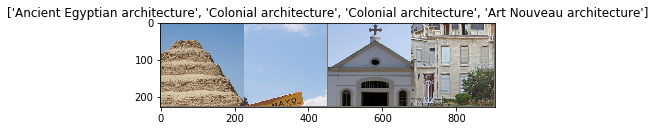

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Model

We shall test fine-tuning and fixed feature extraction in our models to classify architecture.

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'dev']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients.
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'dev' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best dev Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['dev']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Experiments

In [15]:
def create_model(model_name, is_fixed_feature_extraction):
    model = None
    num_ftrs = 0
    if model_name == 'densenet':
        model = models.densetnet121(pretrained=True)
        if is_fixed_feature_extraction:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 25)
    elif model_name == 'resnet':
        model = models.resnet18(pretrained=True)
        if is_fixed_feature_extraction:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 25)
    elif model_name == 'inception':
        model = models.inception_v3(pretrained=True)
        if is_fixed_feature_extraction:
            for param in model.parameters():
                param.requires_grad = False
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 25)
    model = model.to(device)
    return model

In [ ]:
def run_model(model):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    model = train_model(model, criterion, optimizer, exp_lr_scheduler)
    visualize_model(model)

In [16]:
model_names = ['densenet', 'resnet', 'inception']

for model_name in model_names:
    for is_fixed_feature_extraction in [True, False]:
        print('Model: ' + model_name)
        print('Fixed Feature Extraction: ' + is_fixed_feature_extraction)
        model = create_model(model_name, is_fixed_feature_extraction)
        run_model(model)

|Model|Dev Accuracy|
|-|-|
|DenseNet (FFE)|0.x|
|DenseNet (FT)|0.x|
|ResNet (FFE)|0.x|
|ResNet (FT)|0.x|
|Inception (FFE)|0.x|
|Inception (FT)|0.x|

## Acknowledgements & Resources

- For our dataset building portion, we drew inspiration from [CS230 Code Examples](https://github.com/cs230-stanford/cs230-code-examples).
- Much of the transfer learning code for this notebook is taken from the [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).